In [1]:
#Imports

import numpy as np
import os
import h5py
import segmentation_models_pytorch as smp
import pytorch_lightning as pl
from torch.optim import lr_scheduler
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
from collections import OrderedDict
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle
from tabulate import tabulate
from PIL import Image
import albumentations as A

d:\ANACONDA\lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
print(torch.cuda.is_available())
print(torch.version.cuda)

True
12.4


 **Data Processsing**

In [4]:
# Directory containing .h5 files
directory = "/Research Project/Data/BraTS2020_training_data/content/data"

# Create a list of all .h5 files in the directory
h5_files = [f for f in os.listdir(directory) if f.endswith('.h5')]
print(f"Found {len(h5_files)} .h5 files:\nExample file names:{h5_files[:3]}")

# Open the first .h5 file in the list to inspect its contents
if h5_files:
    file_path = os.path.join(directory, h5_files[25070])
    with h5py.File(file_path, 'r') as file:
        print("\nKeys for each file:", list(file.keys()))
        for key in file.keys():
            print(f"\nData type of {key}:", type(file[key][()]))
            print(f"Shape of {key}:", file[key].shape)
            print(f"Array dtype: {file[key].dtype}")
            print(f"Array max val: {np.max(file[key])}")
            print(f"Array min val: {np.min(file[key])}")
else:
    print("No .h5 files found in the directory.")
    
    
# Select GPU device for the training if available
if not torch.cuda.is_available():
    device=torch.device("cpu")
    print("Current device:", device)
else:
    device=torch.device("cuda")
    print("Current device:", device, "- Type:", torch.cuda.get_device_name(0))




Found 57195 .h5 files:
Example file names:['volume_100_slice_0.h5', 'volume_100_slice_1.h5', 'volume_100_slice_10.h5']

Keys for each file: ['image', 'mask']

Data type of image: <class 'numpy.ndarray'>
Shape of image: (240, 240, 4)
Array dtype: float64
Array max val: 4.755863264388587
Array min val: -0.5070322108800785

Data type of mask: <class 'numpy.ndarray'>
Shape of mask: (240, 240, 3)
Array dtype: uint8
Array max val: 1
Array min val: 0
Current device: cuda - Type: NVIDIA GeForce RTX 3060 Ti


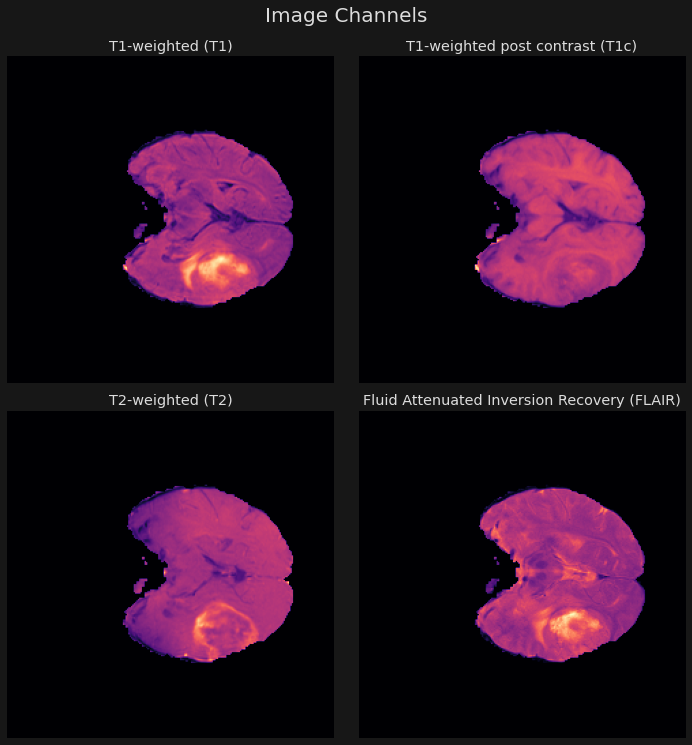

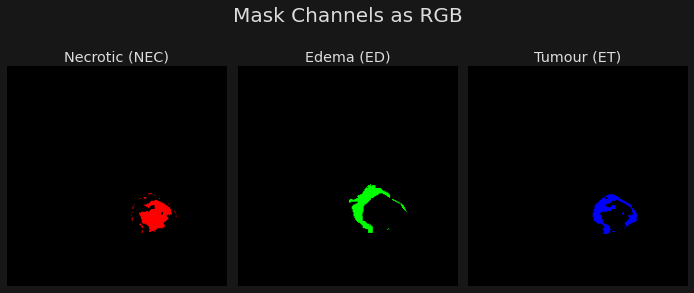

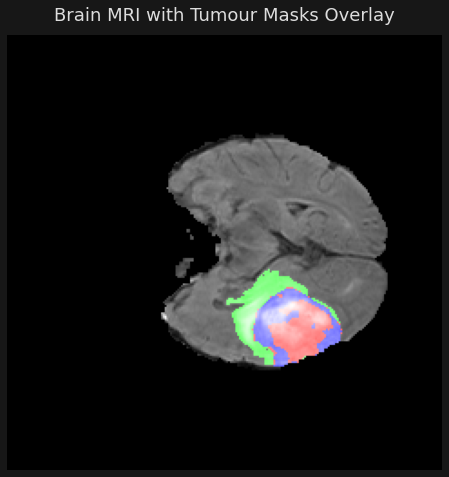

In [5]:
plt.style.use('ggplot')
plt.rcParams['figure.facecolor'] = '#171717'
plt.rcParams['text.color']       = '#DDDDDD'

def display_image_channels(image, title='Image Channels'):
    channel_names = ['T1-weighted (T1)', 'T1-weighted post contrast (T1c)', 'T2-weighted (T2)', 'Fluid Attenuated Inversion Recovery (FLAIR)']
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    for idx, ax in enumerate(axes.flatten()):
        channel_image = image[idx, :, :]  # Transpose the array to display the channel
        ax.imshow(channel_image, cmap='magma')
        ax.axis('off')
        ax.set_title(channel_names[idx])
    plt.tight_layout()
    plt.suptitle(title, fontsize=20, y=1.03)
    plt.show()

def display_mask_channels_as_rgb(mask, title='Mask Channels as RGB'):
    channel_names = ['Necrotic (NEC)', 'Edema (ED)', 'Tumour (ET)']
    fig, axes = plt.subplots(1, 3, figsize=(9.75, 5))
    for idx, ax in enumerate(axes):
        rgb_mask = np.zeros((mask.shape[1], mask.shape[2], 3), dtype=np.uint8)
        rgb_mask[..., idx] = mask[idx, :, :] * 255  # Transpose the array to display the channel
        ax.imshow(rgb_mask)
        ax.axis('off')
        ax.set_title(channel_names[idx])
    plt.suptitle(title, fontsize=20, y=0.93)
    plt.tight_layout()
    plt.show()

def overlay_masks_on_image(image, mask, title='Brain MRI with Tumour Masks Overlay'):
    t1_image = image[0, :, :]  # Use the first channel of the image
    t1_image_normalized = (t1_image - t1_image.min()) / (t1_image.max() - t1_image.min())

    rgb_image = np.stack([t1_image_normalized] * 3, axis=-1)
    color_mask = np.stack([mask[0, :, :], mask[1, :, :], mask[2, :, :]], axis=-1)
    rgb_image = np.where(color_mask, color_mask, rgb_image)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(rgb_image)
    plt.title(title, fontsize=18, y=1.02)
    plt.axis('off')
    plt.show()
    
    
# Sample image to view
sample_file_path = os.path.join(directory, h5_files[25070])
data = {}
with h5py.File(sample_file_path, 'r') as file:
    for key in file.keys():
        data[key] = file[key][()]

# Transpose the image and mask to have channels first
image = data['image'].transpose(2, 0, 1)
mask = data['mask'].transpose(2, 0, 1)

# View images using plotting functions
display_image_channels(image)
display_mask_channels_as_rgb(mask)
overlay_masks_on_image(image, mask)

In [6]:
def pad_to_32(image, mask):
    c_img, h_img, w_img = image.shape
    c_mask, h_mask, w_mask = mask.shape

    # Calculate padding for height and width to make them divisible by 32
    pad_h = (32 - h_img % 32) % 32
    pad_w = (32 - w_img % 32) % 32

    # Pad image
    padding = (0, pad_w, 0, pad_h)  # (left, right, top, bottom)
    image = F.pad(image, padding)
    mask = F.pad(mask, padding)

    return image, mask

In [7]:
class BrainScanDataset(Dataset):
    def __init__(self, file_paths, deterministic=False):
        self.file_paths = file_paths
        if deterministic:  # To always generate the same test images for consistency
            np.random.seed(1)
        np.random.shuffle(self.file_paths)
        
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
    # Load h5 file, get image and mask
        file_path = self.file_paths[idx]
        with h5py.File(file_path, 'r') as file:
            image = file['image'][()]
            mask = file['mask'][()]

        # Reshape image: (H, W, C) -> (C, H, W)
        image = image.transpose((2, 0, 1))

        # Adjust pixel values for each channel in the image so they are between 0 and 1
        for i in range(image.shape[0]):    # Iterate over channels
            min_val = np.min(image[i])     # Find the min value in the channel
            image[i] = image[i] - min_val  # Shift values to ensure min is 0
            max_val = np.max(image[i]) + 1e-4     # Find max value to scale max to 1 now.
            image[i] = image[i] / max_val

        # Convert image to tensor
        image = torch.tensor(image, dtype=torch.float32)

        # Process mask
        # If your mask is one-hot encoded with shape (H, W, C), convert it to (H, W) with class indices
        # First, transpose mask to (C, H, W)
        mask = mask.transpose((2, 0, 1))
        
        #Setting label 4 to 3 to avoid issues
        mask[mask == 4] = 3

        # Convert mask from one-hot encoding to class indices
        mask = np.argmax(mask, axis=0)  # Now mask shape is (H, W)
        
        # Add channel dimension to mask
        mask = np.expand_dims(mask, axis=0)  # Now mask shape is (1, H, W)
        
        # Convert mask to tensor
        mask = torch.tensor(mask, dtype=torch.long)
        
        # Apply any padding if necessary
        image, mask = pad_to_32(image, mask)

        return image, mask

# Build .h5 file paths from directory containing .h5 files
h5_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.h5')]
np.random.seed(42)
np.random.shuffle(h5_files)

# Split the dataset into train and validation sets (90:10)
split_idx = int(0.9 * len(h5_files))
train_files = h5_files[:split_idx]
test_files = h5_files[split_idx:]

# Create the train and val datasets
train_dataset = BrainScanDataset(train_files)
test_dataset = BrainScanDataset(test_files, deterministic=True)

# Sample dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Use this to generate test images to view later
test_input_iterator = iter(DataLoader(test_dataset, batch_size=1, shuffle=False))

# Verifying dataloaders work
for images, masks in train_dataloader:
    print("Training batch - Images shape:", images.shape, "Masks shape:", masks.shape)
    break
for images, masks in test_dataloader:
    print("Validation batch - Images shape:", images.shape, "Masks shape:", masks.shape)
    break


Training batch - Images shape: torch.Size([16, 4, 256, 256]) Masks shape: torch.Size([16, 1, 256, 256])
Validation batch - Images shape: torch.Size([16, 4, 256, 256]) Masks shape: torch.Size([16, 1, 256, 256])


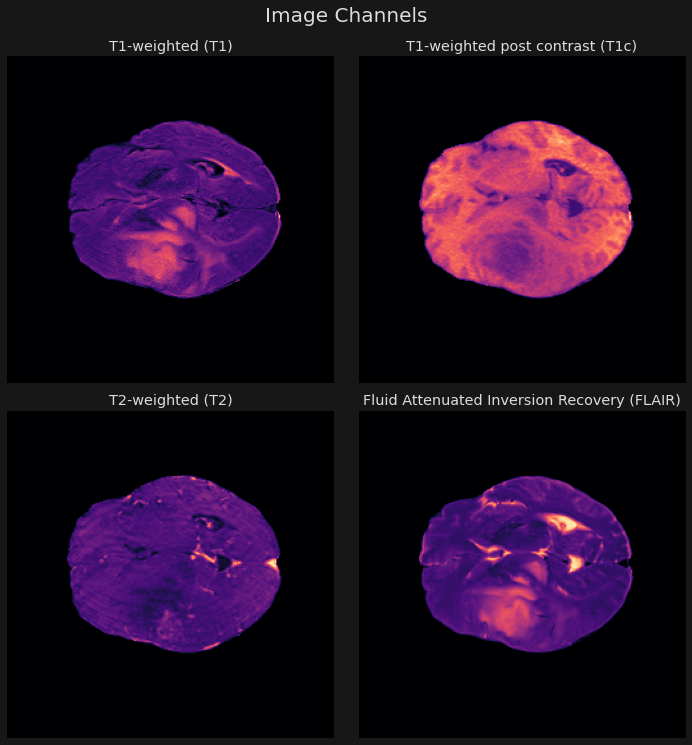

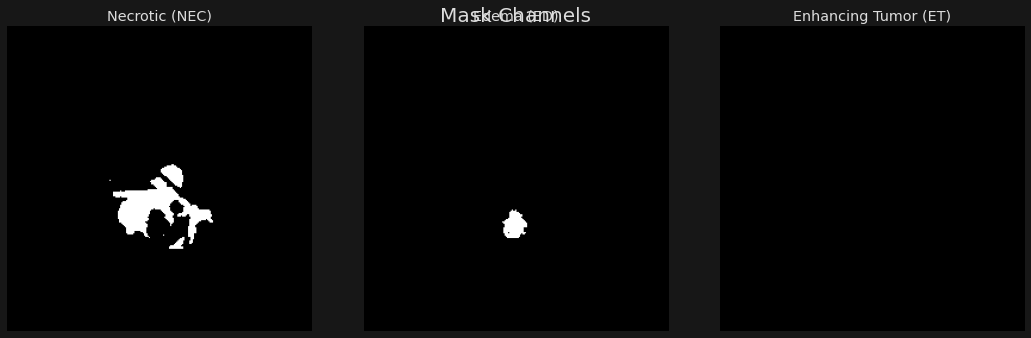

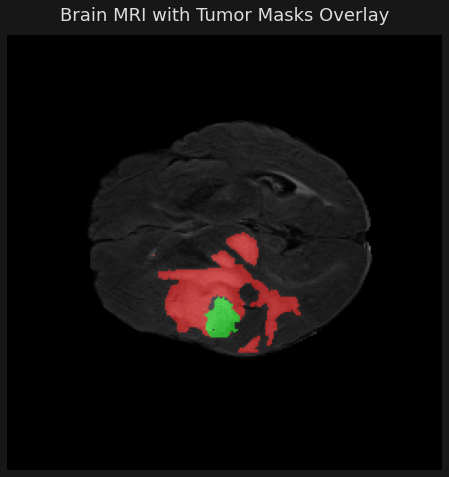

In [9]:
plt.style.use('ggplot')
plt.rcParams['figure.facecolor'] = '#171717'
plt.rcParams['text.color'] = '#DDDDDD'

def display_image_channels(image, title='Image Channels'):
    channel_names = ['T1-weighted (T1)', 'T1-weighted post contrast (T1c)', 'T2-weighted (T2)', 'Fluid Attenuated Inversion Recovery (FLAIR)']
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    for idx, ax in enumerate(axes.flatten()):
        channel_image = image[idx, :, :]
        ax.imshow(channel_image, cmap='magma')
        ax.axis('off')
        ax.set_title(channel_names[idx], color='#DDDDDD')
    plt.tight_layout()
    plt.suptitle(title, fontsize=20, y=1.03, color='#DDDDDD')
    plt.show()

def display_mask_channels(mask, title='Mask Channels'):
    # Assuming mask is a 2D array of shape (H, W) with class indices
    channel_names = ['Necrotic (NEC)', 'Edema (ED)', 'Enhancing Tumor (ET)']
    class_indices = [1, 2, 3]  # Exclude background (0)

    fig, axes = plt.subplots(1, len(class_indices), figsize=(15, 5))
    for idx, class_idx in enumerate(class_indices):
        binary_mask = (mask == class_idx).astype(np.uint8)
        ax = axes[idx]
        ax.imshow(binary_mask, cmap='gray')
        ax.axis('off')
        ax.set_title(channel_names[idx], color='#DDDDDD')
    plt.suptitle(title, fontsize=20, y=0.93, color='#DDDDDD')
    plt.tight_layout()
    plt.show()

def overlay_masks_on_image(image, mask, title='Brain MRI with Tumor Masks Overlay'):
    t1_image = image[0, :, :]  # Use the first channel (T1-weighted)
    t1_image_normalized = (t1_image - t1_image.min()) / (t1_image.max() - t1_image.min())

    rgb_image = np.stack([t1_image_normalized]*3, axis=-1)

    # Define colors for each class
    colors = {
        1: [1, 0, 0],  # Red for Necrotic
        2: [0, 1, 0],  # Green for Edema
        3: [0, 0, 1],  # Blue for Enhancing Tumor
    }

    # Create a color mask
    color_mask = np.zeros_like(rgb_image)
    for class_idx, color in colors.items():
        binary_mask = (mask == class_idx)
        for c in range(3):
            color_mask[..., c] += binary_mask * color[c]

    # Overlay the color mask onto the image with transparency
    alpha = 0.5  # Transparency factor
    overlay_image = (1 - alpha) * rgb_image + alpha * color_mask

    plt.figure(figsize=(8, 8))
    plt.imshow(overlay_image)
    plt.title(title, fontsize=18, y=1.02, color='#DDDDDD')
    plt.axis('off')
    plt.show()

# Retrieve a sample from the test dataset
sample_image, sample_mask = test_dataset[9]  # Get the first sample

# Convert tensors to numpy arrays for visualization
sample_image = sample_image.numpy()
sample_mask = sample_mask.squeeze(0).numpy()  # Remove the channel dimension from mask

# Display the images and masks
display_image_channels(sample_image)
display_mask_channels(sample_mask)
overlay_masks_on_image(sample_image, sample_mask)

In [ ]:
for i in range(1000): 
    sample_file_path = test_files[i]  # Access each file in the list
    
    with h5py.File(sample_file_path, 'r') as file:
        mask = file['mask'][()]
        # If mask is one-hot encoded, convert it to class indices
        mask = np.argmax(mask, axis=2)  # Assuming mask shape is (H, W, C)
    
    unique_labels = np.unique(mask)
    print(f"Unique labels in the mask for file {i}:", unique_labels)


Unique labels in the mask for file 0: [0 1 2]
Unique labels in the mask for file 1: [0 1]
Unique labels in the mask for file 2: [0]
Unique labels in the mask for file 3: [0 1]
Unique labels in the mask for file 4: [0]
Unique labels in the mask for file 5: [0]
Unique labels in the mask for file 6: [0 1 2]
Unique labels in the mask for file 7: [0]
Unique labels in the mask for file 8: [0]
Unique labels in the mask for file 9: [0 1 2]
Unique labels in the mask for file 10: [0]
Unique labels in the mask for file 11: [0 1]
Unique labels in the mask for file 12: [0]
Unique labels in the mask for file 13: [0]
Unique labels in the mask for file 14: [0]
Unique labels in the mask for file 15: [0]
Unique labels in the mask for file 16: [0 1 2]
Unique labels in the mask for file 17: [0]
Unique labels in the mask for file 18: [0 1 2]
Unique labels in the mask for file 19: [0]
Unique labels in the mask for file 20: [0]
Unique labels in the mask for file 21: [0]
Unique labels in the mask for file 22:

In [10]:
class Model(pl.LightningModule):
    def __init__(self, arch, encoder_name, encoder_weights, in_channels, out_classes, **kwargs):
        super().__init__()
        self.num_classes = out_classes
        self.model = smp.create_model(
            arch,
            encoder_name=encoder_name,
            encoder_weights=encoder_weights,
            in_channels=in_channels,
            classes=out_classes,
            **kwargs,
        )
        
        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name, pretrained=encoder_weights)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.MULTICLASS_MODE, from_logits=True)

        # initialize step metics
        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []

    def forward(self, image):
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        
        image, mask = batch

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        logits_mask = self.forward(image)

        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        
        # Convert logits to probabilities
        prob_mask = logits_mask.softmax(dim=1)  # Multi-class uses softmax along the channel axis

        # Obtain the predicted class indices
        pred_mask = prob_mask.argmax(dim=1)  # Shape: (batch_size, height, width)

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(
        pred_mask.long(),
        mask.long(),
        mode="multiclass",
        num_classes=self.num_classes,
        )
        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs], dim=0)
        fp = torch.cat([x["fp"] for x in outputs], dim=0)
        fn = torch.cat([x["fn"] for x in outputs], dim=0)
        tn = torch.cat([x["tn"] for x in outputs], dim=0)

        # per image IoU means that we first calculate IoU score for each image
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(
        tp, fp, fn, tn, reduction="micro-imagewise", mode="multiclass"
        )
        
        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset
        # with "empty" images (images without target class) a large gap could be observed.
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        
        dataset_iou = smp.metrics.iou_score(
        tp, fp, fn, tn, reduction="micro", mode="multiclass"
        )

        metrics = {
        f"{stage}_per_image_iou": per_image_iou,
        f"{stage}_dataset_iou": dataset_iou,
    }

        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        train_loss_info = self.shared_step(batch, "train")
        # append the metrics of each step to the
        self.training_step_outputs.append(train_loss_info)
        return train_loss_info

    def on_train_epoch_end(self):
        self.shared_epoch_end(self.training_step_outputs, "train")
        # empty set output list
        self.training_step_outputs.clear()
        return

    def validation_step(self, batch, batch_idx):
        valid_loss_info = self.shared_step(batch, "valid")
        self.validation_step_outputs.append(valid_loss_info)
        return valid_loss_info

    def on_validation_epoch_end(self):
        self.shared_epoch_end(self.validation_step_outputs, "valid")
        self.validation_step_outputs.clear()
        return

    def test_step(self, batch, batch_idx):
        test_loss_info = self.shared_step(batch, "test")
        self.test_step_outputs.append(test_loss_info)
        return test_loss_info

    def on_test_epoch_end(self):
        self.shared_epoch_end(self.test_step_outputs, "test")
        # empty set output list
        self.test_step_outputs.clear()
        return

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=2e-4)
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_MAX, eta_min=1e-5)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
                "frequency": 1,
            },
        }
        return

In [13]:
model = Model("UNET", "resnet34", "imagenet", in_channels=4, out_classes=3)

In [78]:
class BrainModel(pl.LightningModule):
    def __init__(self, model, optimizer, criterion):
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        
    def forward(self, x):
        return self.model(x)
    
    def shared_step(self, batch, stage):
        image, mask = batch
        out = self.forward(image)
        loss = self.criterion(out, mask.long())
        tp, fp, fn, tn = smp.metrics.get_stats(torch.argmax(out, 1).unsqueeze(1), mask.long(), mode='multiclass', num_classes = 4)
        iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="macro-imagewise")
        self.log(f"{stage}_IoU", iou, prog_bar=True, on_epoch=True)
        self.log(f"{stage}_loss", loss) 
        return {"loss": loss, "iou": iou}
        
    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")     

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")
    
    def configure_optimizers(self):
        return self.optimizer

In [79]:
arch = 'unet'
enc_name = 'resnet50'
classes = 4

model = smp.create_model(arch,
                         encoder_name = enc_name,
                         encoder_weights = "imagenet",
                         in_channels = 4,
                         classes = classes).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-03)
criterion = smp.losses.DiceLoss(mode='multiclass', from_logits=True).to(device)
cbs = pl.callbacks.ModelCheckpoint(dirpath = f'./checkpoints_{arch}',
                                   filename = arch, 
                                   verbose = True, 
                                   monitor = 'valid_loss', 
                                   mode = 'min')

In [80]:
pl_model = BrainModel(model, optimizer, criterion)
trainer = pl.Trainer(callbacks=cbs, accelerator='gpu', max_epochs=10)
trainer.fit(pl_model, train_dataloader, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
d:\ANACONDA\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory E:\Research Project\checkpoints_unet exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type     | Params | Mode 
-----------------------------------------------
0 | model     | Unet     | 32.5 M | train
1 | criterion | DiceLoss | 0      | train
-----------------------------------------------
32.5 M    Trainable params
0         Non-trainable params
32.5 M    Total params
130.099   Total estimated model params size (MB)
224       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

d:\ANACONDA\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


AssertionError: 

In [33]:
model = smp.create_model(arch,
                         encoder_name = enc_name,
                         encoder_weights = "imagenet",
                         in_channels = 4,
                         classes = classes).to(device)

state_dict = torch.load(cbs.best_model_path)['state_dict']
pl_state_dict = OrderedDict([(key[6:], state_dict[key]) for key in state_dict.keys()])

model.load_state_dict(pl_state_dict)
model.eval()

<ipython-input-33-f20bb748d5f2>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(cbs.best_model_path)['state_dict']


FileNotFoundError: [Errno 2] No such file or directory: ''

In [ ]:
## TESTING
with torch.no_grad(): 
    
    outputs = []
    test_loss = 0.0
    iou = 0

    for image, mask in tqdm(test_dataloader):       

        image = image.to(device); mask = mask.to(device)
        output = model(image).to(device)
        tp, fp, fn, tn = smp.metrics.get_stats(torch.argmax(output, 1).unsqueeze(1), mask.long(), mode='multiclass', num_classes = 4)
        outputs.append({"tp": tp, "fp": fp, "fn": fn, "tn": tn})
        loss = criterion(output, mask.long()) 
        test_loss += loss.item() 
    
    tp = torch.cat([x["tp"] for x in outputs])
    fp = torch.cat([x["fp"] for x in outputs])
    fn = torch.cat([x["fn"] for x in outputs])
    tn = torch.cat([x["tn"] for x in outputs])
    
    print(f'Test Loss: {test_loss / len(test_dataloader)}')
    print('IoU:', smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise").item())

100%|██████████| 358/358 [01:47<00:00,  3.32it/s]

Test Loss: 0.06377510767034646
IoU: 0.9954207539558411


<ipython-input-32-29803e1e675a>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.argmax(model(torch.tensor(image).unsqueeze(0).to(device)), 1)


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

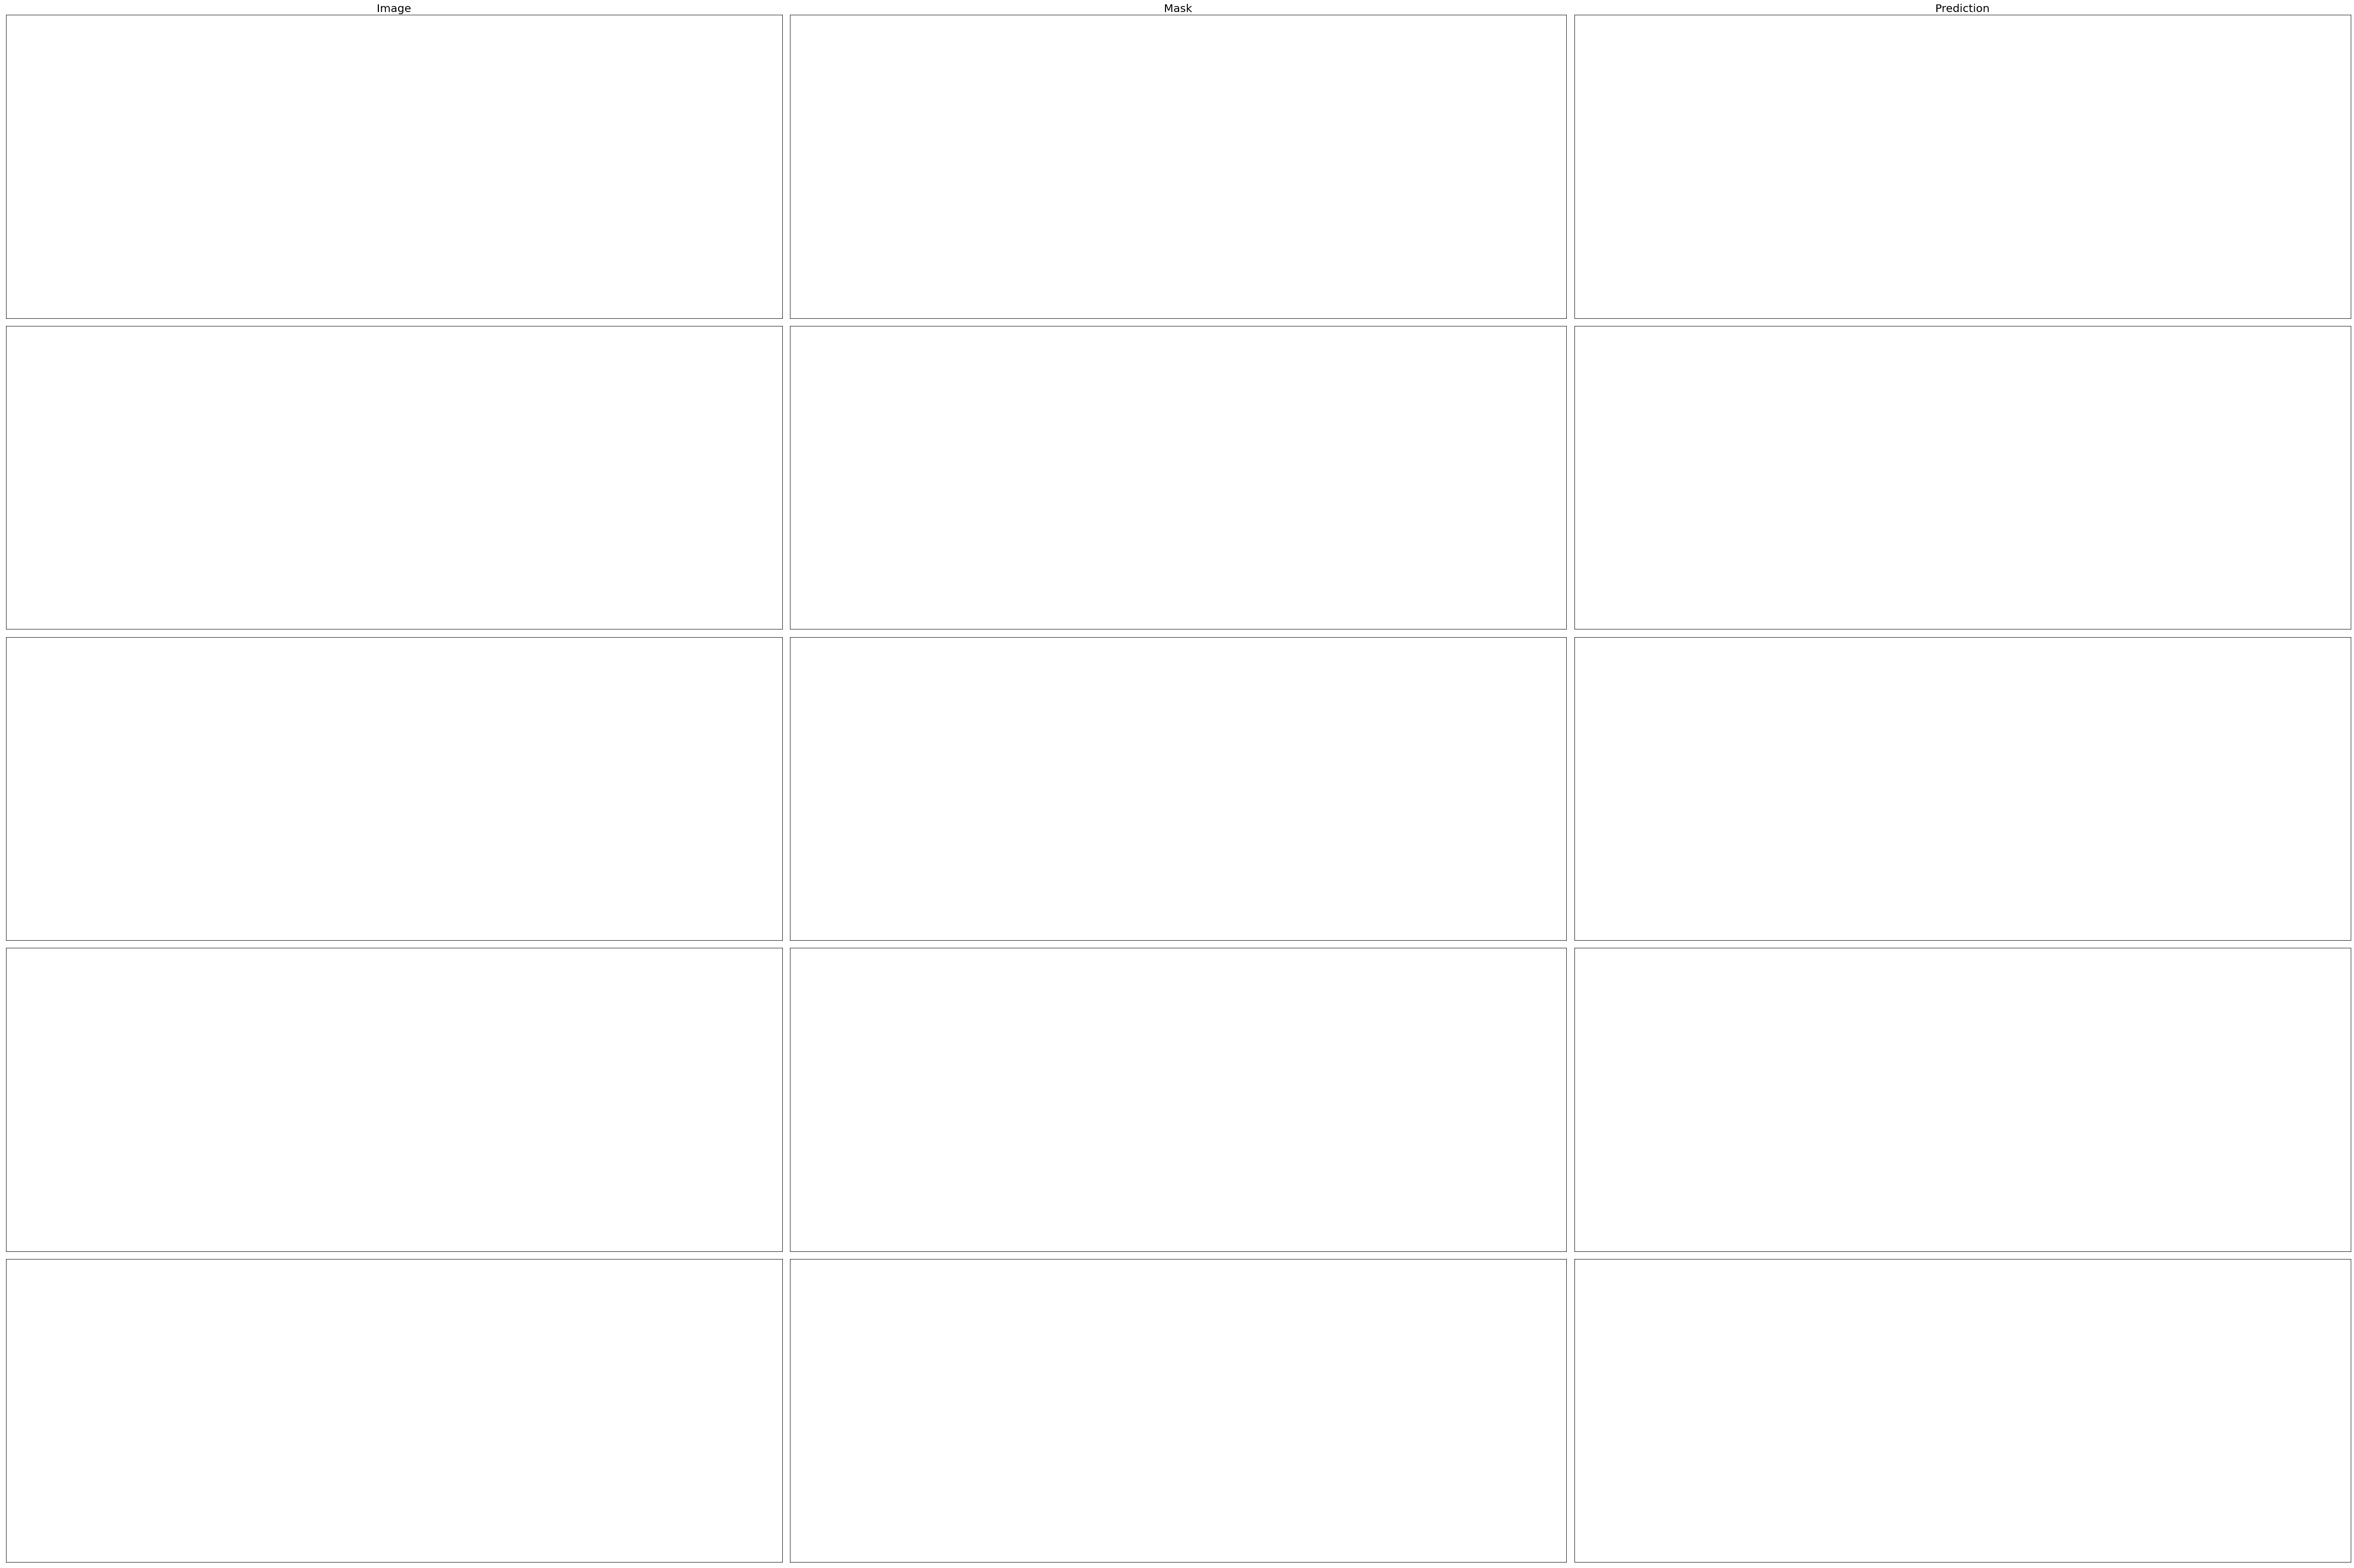

In [ ]:
random.seed(10)
samples = random.sample(range(len(test_dataset)), 5)

#palette = [[155,38,182], [14,135,204], [124,252,0], [255,20,147], [169,169,169]]
#pal = [value for color in palette for value in color]

cols = ['Image', 'Mask', 'Prediction']
fig, axes = plt.subplots(len(samples), 3, figsize=(60, 40), sharex='row', sharey='row', 
                         subplot_kw={'xticks':[], 'yticks':[]}, tight_layout=True)

for ax, col in zip(axes[0], cols): ax.set_title(col, fontsize=20) # set column label --> considered epoch
    
for i in range(len(samples)):
        image, mask = test_dataset[samples[i]]
        pred = torch.argmax(model(torch.tensor(image).unsqueeze(0).to(device)), 1)

        mask = Image.fromarray(mask.squeeze(0)).convert('P')
        pred = Image.fromarray(np.array(pred.squeeze(0).cpu()).astype('uint8')).convert('P')
        #mask.putpalette(pal)
        #pred.putpalette(pal)

        axes[i, 0].imshow(np.array(image).transpose(1, 2, 0))
        axes[i, 1].imshow(mask)
        axes[i, 2].imshow(pred)
        
fig.savefig(arch + '.png')

In [26]:
metrics = np.round(torch.stack([torch.mean(smp.metrics.recall(tp, fp, fn, tn, reduction=None), 0),
                                torch.mean(smp.metrics.false_positive_rate(tp, fp, fn, tn, reduction=None), 0),
                                torch.mean(smp.metrics.false_negative_rate(tp, fp, fn, tn, reduction=None), 0),
                                torch.mean(smp.metrics.iou_score(tp, fp, fn, tn, reduction=None), 0)]).numpy(), 3)

info = {'Metrics': ['Recall', 'FPR', 'FNR', 'IoU'], 
        'Obstacles': metrics[:, 0], 
        'Water': metrics[:, 1],
        'Nature': metrics[:, 2],
        'Moving':metrics[:, 3],
        'Landing': metrics[:, 4]}

table = tabulate(info, headers='keys', tablefmt='fancy_grid')
print(table)

with open('table.txt', 'w') as f:
    f.write(table)

╒═══════════╤═════════════╤═════════╤══════════╤══════════╤═══════════╕
│ Metrics   │   Obstacles │   Water │   Nature │   Moving │   Landing │
╞═══════════╪═════════════╪═════════╪══════════╪══════════╪═══════════╡
│ Recall    │       0.999 │   0.885 │    0.94  │    1     │     1     │
├───────────┼─────────────┼─────────┼──────────┼──────────┼───────────┤
│ FPR       │       0.68  │   0.001 │    0     │    0     │     0     │
├───────────┼─────────────┼─────────┼──────────┼──────────┼───────────┤
│ FNR       │       0.001 │   0.694 │    0.812 │    1     │     1     │
├───────────┼─────────────┼─────────┼──────────┼──────────┼───────────┤
│ IoU       │       0.998 │   0.819 │    0.905 │    0.761 │     0.764 │
╘═══════════╧═════════════╧═════════╧══════════╧══════════╧═══════════╛
